In [200]:
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

truth_measures = pd.read_csv("./debug/measures_2025-06-09_11-32.csv").melt(
    id_vars=["attempt", "store"], var_name="query", value_name="time"
)

original_measures = pd.read_csv(
    "./debug/selections_2025-06-09_22-25.csv")

test_queries = ["Q0", "Q1", "Q4", "Q6", "Q11", "Q7", "Q9"]

truth_measures

,attempt,store,query,time
0,0,duckdb,Q0,1.142630
1,0,trino,Q0,1.223816
2,1,duckdb,Q0,0.455719
3,1,trino,Q0,0.273733
4,2,duckdb,Q0,0.445848
...,...,...,...,...
95,7,trino,Q11,0.656562
96,8,duckdb,Q11,1.008277
97,8,trino,Q11,0.667961
98,9,duckdb,Q11,0.329654


In [75]:
true_comparison_data = (
    truth_measures.pivot(
        index=["attempt", "query"],
        columns="store",
        values="time"
    )
)

# Calculate the difference and whether duckdb is faster
true_comparison_data["trino-duck"] = true_comparison_data["trino"] - true_comparison_data["duckdb"]
true_comparison_data["duckdb_faster"] = (true_comparison_data["trino-duck"] > 0).astype(int)

# Reset index to have 'query' as a column for groupby
true_comparison_data = true_comparison_data.reset_index()

# aggregate the results by query and get mean for trino-duckdb comparison, sum for duckdb_faster
true_comparison_data = (
    true_comparison_data.groupby(by="query")
    .agg(
        mean_trino_duck=("trino-duck", "mean"),
        duckdb_faster=("duckdb_faster", "sum")
    )
    .reset_index()
)

true_comparison_data

,query,mean_trino_duck,duckdb_faster
0,Q0,1.161812,8
1,Q1,-2.256494,8
2,Q11,0.135648,7
3,Q4,36.773668,9
4,Q6,22.333585,9


In [114]:
predicted_measures = original_measures.copy() 
predicted_measures["duckdb_suggested"] = original_measures.apply(
    lambda row: 1 if row["store"] == "duckdb" else 0, axis=1
)

predicted_measures = predicted_measures.groupby("query").agg(
    response_time=("responsetime", "mean"),
    duckdb_suggested=("duckdb_suggested", "sum")
)

# make duckdb_suggested a fraction of the total
predicted_measures["duckdb_suggested_fraction"] = predicted_measures["duckdb_suggested"]

predicted_measures

,response_time,duckdb_suggested,duckdb_suggested_fraction
query,,,
0,8.548302,9,9
1,9.515228,0,0
2,9.989199,0,0
3,9.461690,9,9
4,11.763317,3,3
5,14.787960,0,0
6,16.065063,0,0


In [223]:
# comparison

predictions = original_measures.copy()
predictions["query"] = predictions["query"].transform(lambda q: test_queries[q])

targets = truth_measures.copy()
targets = targets.pivot(
    index=["attempt", "query"],
    columns="store",
    values="time"
).reset_index()

# join the predictions with the targets
joined_data = predictions.merge(
    targets,
    on=["attempt", "query"],
    suffixes=("_p", "_t")
)

joined_data["prediction"] = joined_data["store"].apply(
    lambda x: 1 if x == "duckdb" else 0
)

joined_data["target"] = joined_data.apply(
    lambda x: 1 if x["duckdb"] < x["trino"] else 0, axis=1
)
print(joined_data.head()) 

accuracy_scores = joined_data.copy()
# print("Accuracy")
# print(accuracy_scores.drop_duplicates(subset=["Query"]))
accuracy_scores = accuracy_scores[["query", "prediction", "target"]].groupby(
    ["query"]
).apply(
    lambda x: pd.Series({
            "F1 Score": skl.metrics.f1_score(x["prediction"], x["target"],average="macro"),
            "Accuracy": skl.metrics.accuracy_score(x["prediction"], x["target"]),
            "Precision": skl.metrics.precision_score(x["prediction"], x["target"], average="macro"),
            "Recall": skl.metrics.recall_score(x["prediction"], x["target"], average="macro")
        })
).reset_index().rename(
    columns={"query": "Query"}
)


print(accuracy_scores)


f1 = skl.metrics.f1_score(joined_data["prediction"], joined_data["target"], average="macro")
accuracy = skl.metrics.accuracy_score(joined_data["prediction"], joined_data["target"])
precision = skl.metrics.precision_score(joined_data["prediction"], joined_data["target"], average="macro")
recall = skl.metrics.recall_score(joined_data["prediction"], joined_data["target"], average="macro")

   attempt query   store  responsetime      duckdb       trino  prediction  \
0        0    Q0  duckdb      8.471358    1.142630    1.223816           1   
1        0    Q1   trino      9.124822  349.802107   70.729204           0   
2        0    Q4   trino     11.351159  329.098459  112.881751           0   
3        0    Q6  duckdb     10.021532  124.566218   79.289354           1   
4        0   Q11  duckdb     12.183592    1.169979    1.294875           1   

   target  
0       1  
1       0  
2       0  
3       0  
4       1  
  Query  F1 Score  Accuracy  Precision    Recall
0    Q0  0.437500  0.777778        0.5  0.388889
1    Q1  0.181818  0.222222        0.5  0.111111
2   Q11  0.444444  0.444444        0.5  0.500000
3    Q4  0.100000  0.111111        0.5  0.055556
4    Q6  0.470588  0.888889        0.5  0.444444


/Users/sriramrao/Code/tensorstax/queryrouter/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sriramrao/Code/tensorstax/queryrouter/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sriramrao/Code/tensorstax/queryrouter/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

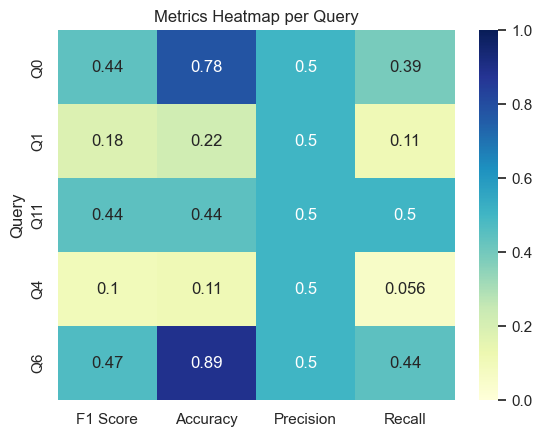

In [231]:
sns.heatmap(accuracy_scores.set_index('Query'), annot=True, cmap='YlGnBu', vmin=0, vmax=1)
plt.title('Metrics Heatmap per Query')
plt.savefig('debug/charts/metrics_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()

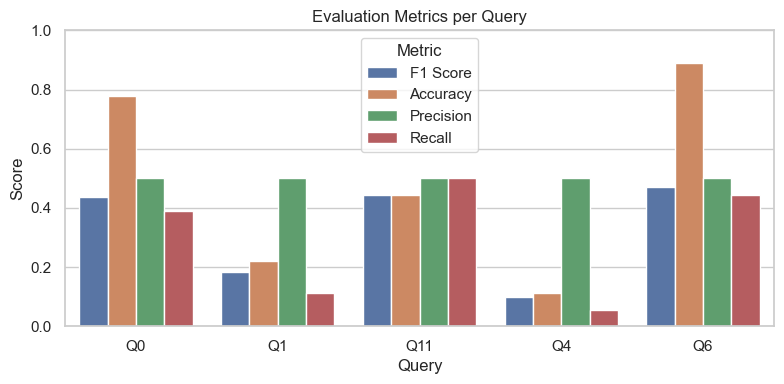

In [232]:
scores = accuracy_scores.melt(id_vars='Query', var_name='Metric', value_name='Score')


sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.barplot(data=scores, x='Query', y='Score', hue='Metric')
plt.title('Evaluation Metrics per Query')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('debug/charts/metrics_bar.pdf', dpi=300, bbox_inches='tight')
plt.show()

  Query  F1 Score  Accuracy  Precision    Recall
0    Q0  0.437500  0.777778        0.5  0.388889
1    Q1  0.181818  0.222222        0.5  0.111111
2   Q11  0.444444  0.444444        0.5  0.500000
3    Q4  0.100000  0.111111        0.5  0.055556
4    Q6  0.470588  0.888889        0.5  0.444444


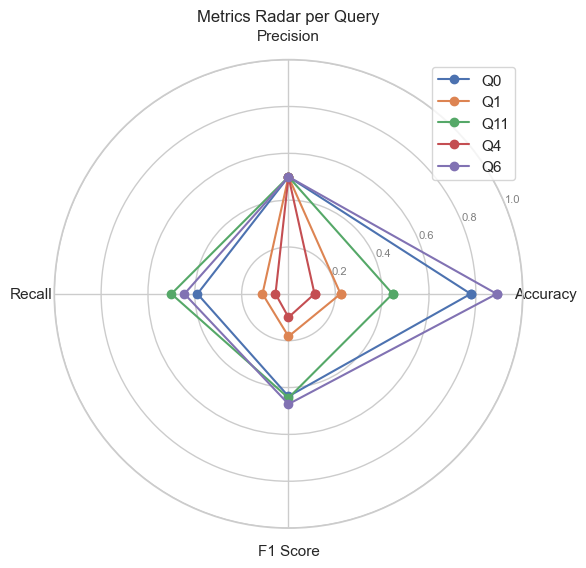

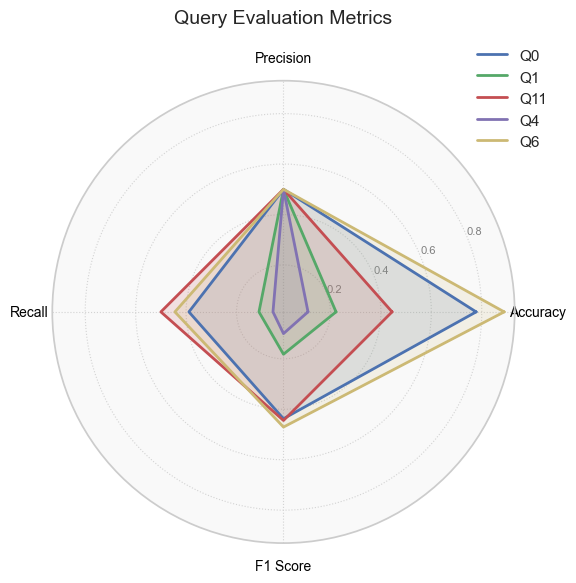

In [235]:
print(accuracy_scores.head())
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # loop back

scores = accuracy_scores.reset_index()
plt.figure(figsize=(6, 6))
for i, row in scores.iterrows():
    values = row[labels].tolist()
    values += values[:1]
    plt.polar(angles, values, label=row['Query'], marker='o')

plt.xticks(angles[:-1], labels)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], color='gray', size=8)
plt.title("Metrics Radar per Query")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Setup
metrics = labels
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

# Plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)

# Style
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974']
ax.set_facecolor('#f9f9f9')
plt.xticks(angles[:-1], metrics, fontsize=10, color='black')
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=8, color='gray')
ax.grid(color='lightgray', linestyle='dotted', linewidth=0.8)

# Plot each query
for i, row in scores.iterrows():
    values = row[metrics].tolist() + [row[metrics[0]]]
    ax.plot(angles, values, label=row["Query"], color=colors[i], linewidth=2)
    ax.fill(angles, values, color=colors[i], alpha=0.15)

# Legend and title
plt.title('Query Evaluation Metrics', fontsize=14, pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), frameon=False)
plt.tight_layout()
plt.savefig('debug/charts/metrics_radar.pdf', dpi=300, bbox_inches='tight')
plt.show()

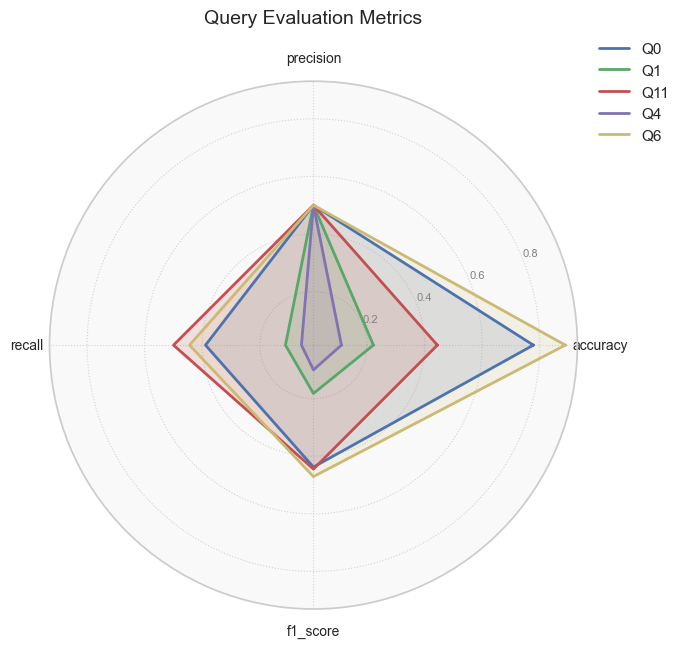

In [207]:
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

# Color palette (5 distinct)
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974']

# Plot
plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)
ax.set_facecolor('#f9f9f9')

plt.xticks(angles[:-1], metrics, fontsize=10)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=8, color='gray')
ax.grid(color='lightgray', linestyle='dotted', linewidth=0.8)

for i, row in accuracy_scores.iterrows():
    values = row[metrics].tolist() + [row[metrics[0]]]
    ax.plot(angles, values, label=row['query'], color=colors[i], linewidth=2)
    ax.fill(angles, values, color=colors[i], alpha=0.15)

plt.title('Query Evaluation Metrics', fontsize=14, pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), frameon=False)
plt.tight_layout()
plt.show()

In [ ]:
bar_data = joined_data.copy()
bar_data["Empirical Choice"] = bar_data.apply(
    lambda x: "DuckDB" if x["duckdb"] < x["trino"] else "Trino", axis=1
)
# rename store to predicted store in the data frame 
bar_data.rename(columns={"store": "Predicted Choice", "query": "Query"}, inplace=True)

bar_data = bar_data[["Query", "Empirical Choice", "Predicted Choice", "duckdb", "trino"]].melt(
    id_vars=["Query", "duckdb", "trino"],
    value_vars=["Empirical Choice", "Predicted Choice"],
    var_name="Observation",
    value_name="Observation Value"
).melt(
    id_vars=["Query", "Observation Value", "Observation"],
    value_vars=["duckdb", "trino"],
    var_name="Executed Engine",
    value_name="Execution Time"
).sort_values(
    by=["Query", "Executed Engine"]
)

bar_data
# sns.set_theme(style="whitegrid")
# plt.figure(figsize=(12, 6))
# sns.barplot(
#     data=bar_data,
#     x="Query",
#     y="Execution Time",
#     hue="Executed Engine",
#     hue_order=["duckdb", "trino"],
#     errorbar=("ci", 95),
#     palette=["#1f77b4", "#ff7f0e"]
# )

,Query,Observation Value,Observation,Executed Engine,Execution Time
0,Q0,DuckDB,Empirical Choice,duckdb,1.142630
5,Q0,Trino,Empirical Choice,duckdb,0.455719
10,Q0,Trino,Empirical Choice,duckdb,0.445848
15,Q0,DuckDB,Empirical Choice,duckdb,0.462799
20,Q0,DuckDB,Empirical Choice,duckdb,0.447955
...,...,...,...,...,...
158,Q6,duckdb,Predicted Choice,trino,79.983454
163,Q6,duckdb,Predicted Choice,trino,78.825141
168,Q6,duckdb,Predicted Choice,trino,76.291991
173,Q6,duckdb,Predicted Choice,trino,76.832502


/var/folders/db/gks7g8x17m30nv0fvvm6mcx00000gn/T/ipykernel_7856/1025479721.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Metric', y='Score', palette=palette)


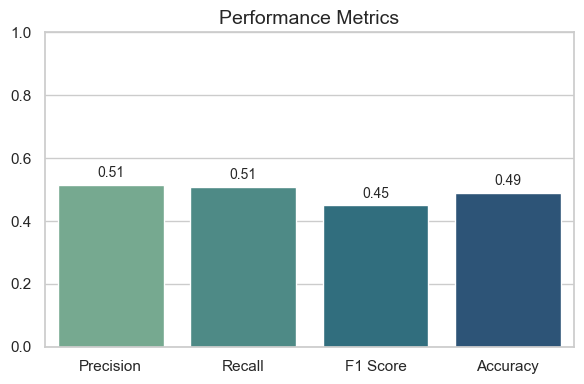

In [234]:
# Your metric values
# precision = 0.87
# recall = 0.90
# f1 = 0.88
# accuracy = 0.91

# Prepare data
df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
    'Score': [precision, recall, f1_score, accuracy]
})

# Plot
# sns.set(style="whitegrid")
# ax = sns.barplot(data=df, x='Metric', y='Score')
# ax.set_ylim(0, 1)
# ax.set_title('Model Performance')
# for i, v in enumerate(df['Score']):
#     ax.text(i, v + 0.01, f"{v:.2f}", ha='center')
# plt.show()

# Style
sns.set_theme(style="whitegrid")
palette = sns.color_palette("crest", len(df))

# Plot
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=df, x='Metric', y='Score', palette=palette)
ax.set_ylim(0, 1)
ax.set_title('Performance Metrics', fontsize=14)
ax.set_ylabel('')
ax.set_xlabel('')

# Add value labels
for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.015,
        f"{bar.get_height():.2f}",
        ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.savefig('debug/charts/metrics_summary.pdf', dpi=300, bbox_inches='tight')
plt.show()


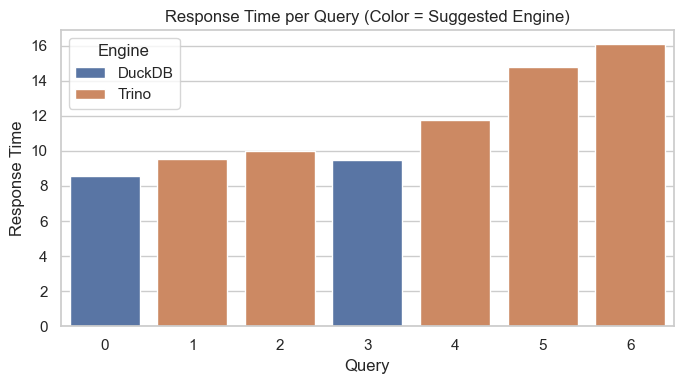

In [ ]:
# Sample data
df = predicted_measures

# Label engine
df['engine'] = df['duckdb_suggested'].apply(lambda x: 'DuckDB' if x > 5 else 'Trino')

# Plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 4))
ax = sns.barplot(data=df, x='query', y='response_time', hue='engine', dodge=False,
            palette={'DuckDB': '#4C72B0', 'Trino': '#DD8452'})
ax.legend(title='Engine')
plt.title('Response Time per Query (Color = Suggested Engine)')
plt.xlabel('Query')
plt.ylabel('Response Time')
plt.tight_layout()
plt.show()